# App code for the cat-translator model

This notebook explores Python code for more than just testing our cat-translator Visual Recognition model.  This notebook prototypes code for processing audio, generating spectrograms, and sending the spectrograms to the Visual Recognition model.  Prototyping code here can make creating a web app later easier.

- Step 1: Install and import required libraries
- Step 2: Download sample video files
- Step 3: Extract meow sound
- Step 4: Create a spectrogram of the meow sound
- Step 5: Classify the spectrogram
- Step 6: Generate speech using Watson Text to Speech
- Step 7: Explore the full process - from video, to classification, to speech


## Step 1: Install and import required libraries

- [wget](https://pypi.org/project/wget/) for downloading sample video files to the notebook working directory
- [moviepy](https://zulko.github.io/moviepy/index.html) for easily working with the audio of the videos
- [librosa](https://librosa.github.io/librosa/) for creating a spectrogram of the audio snippet
- [Pillow](https://pillow.readthedocs.io/en/5.3.x/reference/Image.html) for resizing the spectrogram images
- watson_developer_cloud for working with [Watson Visual Recognition API](https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/python.html?python) and [Watson Text to Speech API](https://cloud.ibm.com/apidocs/text-to-speech?code=python)

In [ ]:
!pip install wget

In [ ]:
# !pip install --upgrade moviepy
#
# [2019-03-17]
# Can't simply install moviepy, because you get this error later when trying to import moviepy for use:
# https://stackoverflow.com/questions/54803180/deprecation-error-when-using-imageio-ffmpeg-download
#
# This is due to a temporary problem introduced by changes in a library moviepy depends on, imageio:
# https://github.com/Zulko/moviepy/issues/906
#
# *It's affecting lots of libraries that use imageio
# https://github.com/epic-kitchens/epic-lib/issues/69
#
# Work around: before installing moviepy, install underlying libs
!pip install imageio==2.4.1
import imageio
imageio.plugins.ffmpeg.download()

In [ ]:
!pip install moviepy

In [ ]:
!pip install librosa

In [ ]:
!pip install --upgrade watson-developer-cloud

In [6]:
import wget
from moviepy.editor import *
import warnings
import matplotlib
import matplotlib.pyplot as plt
import re
import librosa
import librosa.display
import numpy as np
from PIL import Image
from watson_developer_cloud import VisualRecognitionV3
import json
from watson_developer_cloud import TextToSpeechV1

## Step 2: Download sample video files
To work with two sample videos, use wget to download the videos directly from GitHub to the notebook working directory.

In [7]:
!rm -f *.mp4
!rm -f *.mp3
!rm -f *.png
!rm -f *.wav
filename_1 = 'opendoor.mp4'
filename_2 = 'feedme.mp4'
url_base = 'https://github.com/IBMDataScience/Watson-Studio-Examples/raw/master/Cat-translator/cat-translator-web-app/code/static/'
url_1 = url_base + filename_1
url_2 = url_base + filename_2
wget.download( url_1 )
wget.download( url_2 )
!ls -l

total 384
-rw-r----- 1 dsxuser dsxuser 206243 Mar 20 15:28 feedme.mp4
-rw-r----- 1 dsxuser dsxuser 181877 Mar 20 15:28 opendoor.mp4


In [8]:
warnings.filterwarnings( 'ignore', category=UserWarning )
videoclip_1 = VideoFileClip( filename_1 )
videoclip_2 = VideoFileClip( filename_2 )

In [9]:
videoclip_1.ipython_display( width='400' )

t:   0%|          | 0/67 [00:00<?, ?it/s, now=None]    

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [10]:
videoclip_2.ipython_display( width='400' )

t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]    

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in %s
MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Step 3: Extract _meow_ sound

1. Use the audio track from the videos to create a [soundarray](https://zulko.github.io/moviepy/ref/AudioClip.html?highlight=to_soundarray#moviepy.audio.AudioClip.AudioClip.to_soundarray)
2. Using a volume-related heuristic, trim the beginning and end of the audio to get a shorter audio clip of just the sound to analyze

In [11]:
def get_sound_start( soundarray ):
    soundmax = max( [ abs(min(soundarray[:,0])), abs(max(soundarray[:,1])) ] )
    threshold = 0.3 * ( soundmax )
    i = 0
    while ( i < soundarray.shape[0] ) and ( abs( soundarray[i,0] ) < threshold ) and ( abs( soundarray[i,1] ) < threshold ):
        i += 1
    return i

def get_sound_end( soundarray, i ):
    soundmax = max( [ abs(min(soundarray[:,0])), abs(max(soundarray[:,1])) ] )
    threshold = 0.3 * ( soundmax )
    j = ( soundarray.shape[0] - 1 )
    while ( j > i ) and ( abs( soundarray[j,0] ) < threshold ) and ( abs( soundarray[j,1] ) < threshold ):
        j -= 1
    return j

def plot_sound( filename, soundarray, sound_start, sound_end ):
    plt.figure( 1, figsize=( 20, 5 ) )
    plt.plot( soundarray )
    plt.axvline( x=sound_start )
    plt.axvline( x=sound_end )
    plt.title( 'File: '+ filename )
    plt.xlabel( 'Frame number' )
    plt.ylabel( 'Channel volume' )
    plt.show()

def get_trimmed_audio( videoclip ):
    filename = videoclip.filename
    audioclip   = videoclip.audio
    soundarray  = audioclip.to_soundarray( fps=44100, nbytes=4 )
    sound_start = get_sound_start( soundarray ) - 2000
    sound_end   = get_sound_end( soundarray, sound_start ) + 2000
    audioclip_short = audioclip.subclip( sound_start/44100, sound_end/44100 )
    new_filename = re.sub( '.mp4', '.wav', filename )
    audioclip_short.write_audiofile( new_filename, fps=44100, nbytes=4, verbose=False )
    plot_sound( filename, soundarray, sound_start, sound_end )
    return audioclip_short

MoviePy - Writing audio in %s
MoviePy - Done.


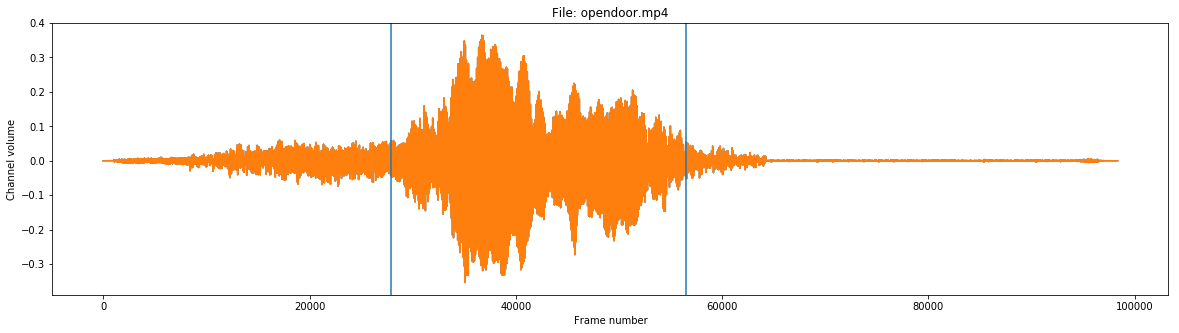

MoviePy - Writing audio in %s
MoviePy - Done.


In [12]:
audio_1 = get_trimmed_audio( videoclip_1 )
audio_1.ipython_display( width='300' )

MoviePy - Writing audio in %s
MoviePy - Done.


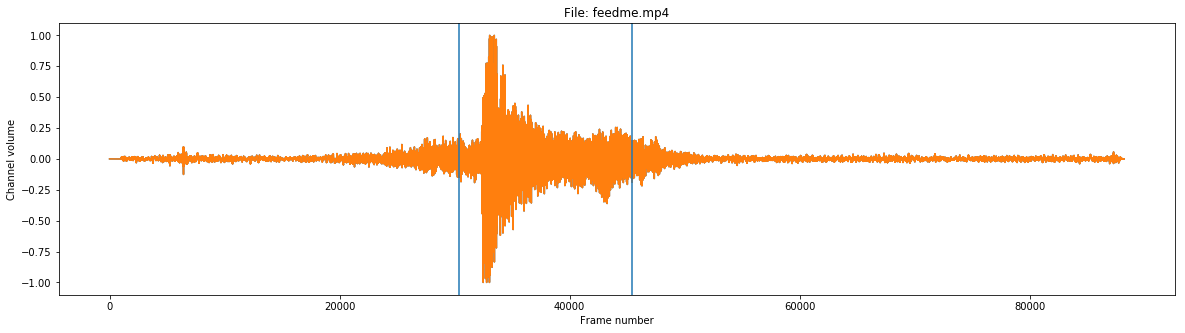

MoviePy - Writing audio in %s
MoviePy - Done.


In [13]:
audio_2 = get_trimmed_audio( videoclip_2 )
audio_2.ipython_display( width='300' )

## Step 4: Create a spectrogram of the _meow_ sound

Using several functions from the librosa library, create a visual representation of the short audio: [stft](https://librosa.github.io/librosa/generated/librosa.core.stft.html), [amplitude_to_db](https://librosa.github.io/librosa/generated/librosa.core.amplitude_to_db.html), and [specshow](https://librosa.github.io/librosa/generated/librosa.display.specshow.html?highlight=specshow#librosa.display.specshow).

What is a "spectrogram"?  See: [Wikipedia](https://en.wikipedia.org/wiki/Spectrogram)

In [14]:
def showSpectrogram( filename ):
    file_base = re.sub( '.mp4$', '', filename )
    infile = file_base + '.wav'
    y, sr = librosa.load( infile )
    plt.figure( figsize=( 10, 5 ) )
    librosa.display.specshow( librosa.amplitude_to_db( np.abs( librosa.stft( y ) ), ref=np.max ), y_axis='log', x_axis='time' )
    plt.colorbar( format='%+2.0f dB')
    plt.title( 'File: ' + filename )

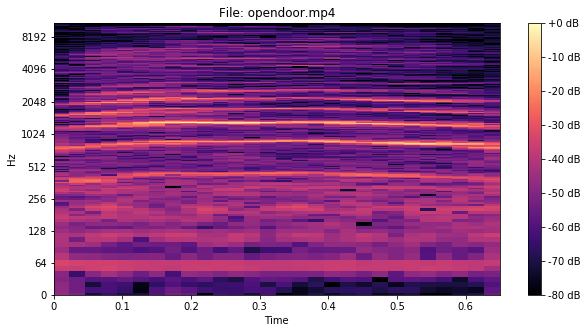

In [15]:
showSpectrogram( filename_1 )

In [16]:
def saveAsSpectrogram( filename ):
    file_base  = re.sub( '.mp4$', '', filename )
    infile     = file_base + '.wav'
    outfile    = file_base + '_lg.png'
    sm_outfile = file_base + '.spec.png'
    y, sr = librosa.load( infile )
    plt.figure( figsize=( 5, 5 ) )
    plt.title( 'File: ' + sm_outfile )
    librosa.display.specshow( librosa.amplitude_to_db( np.abs( librosa.stft( y ) ), ref=np.max ) )
    plt.savefig( outfile, bbox_inches='tight', pad_inches=0.0 )
    im = Image.open( outfile )
    sm_im = im.resize( [ 224, 224 ], resample=Image.LANCZOS )
    sm_im.save( sm_outfile, format="PNG" )
    !rm -f *_lg.png

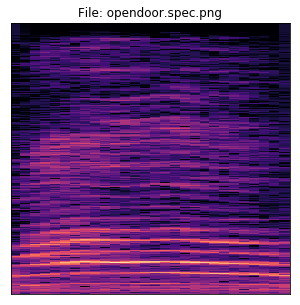

In [17]:
saveAsSpectrogram( filename_1 )

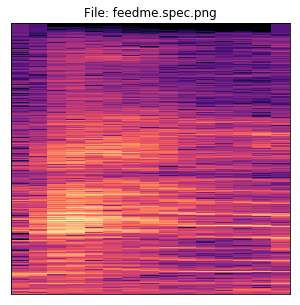

In [18]:
saveAsSpectrogram( filename_2 )

## Step 5: Classify the spectrogram

Use the [Watson Visual Recognition Python client API](https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/python.html?python) to send spectrogram images to our trained model for classification.

### Prerequisite
Look up the apikey for the Visual Recognition service instance and the ID of the custom model:
1. From the **Services** menu in Watson Studio (top of the screen) right-click "Watson Services" and then open the link in a new browser tab
2. In the new Watson services tab, click the service instance in the Visual Recognition list
3. In the **Overview** tab, scroll down to the list of your custom models and then click "Copy model ID"
4. In the **Credentials** tab, expand credentials and then copy the apikey

In [19]:
model_id = "" # <-- PASTE YOUR MODEL ID HERE
apikey   = "" # <-- PASTE YOUR APIKEY HERE

In [20]:
visual_recognition = VisualRecognitionV3( version='2018-03-19', iam_apikey=apikey )

def getKey( item ):
    return item["score"]

def getTopClass( results ):
    results_classes = results["images"][0]["classifiers"][0]["classes"]
    sorted_results_classes = sorted( results_classes, key=getKey, reverse=True )
    return sorted_results_classes[0]

def translateMeow( spec_file_name ):
    with open( spec_file_name, 'rb' ) as image_file:
        results = visual_recognition.classify( image_file, threshold='0', classifier_ids=model_id ).get_result()
        top_class = getTopClass( results )
        return { 'top_class' : top_class, 'results' : results }

In [21]:
results_1 = translateMeow( re.sub( '.mp4', '.spec.png', filename_1 ) )
results_2 = translateMeow( re.sub( '.mp4', '.spec.png', filename_2 ) )
print( filename_1 )
print( results_1["top_class"] )
print( "\n" )
print( filename_2 )
print( results_2["top_class"] )

opendoor.mp4
{'score': 0.782, 'class': 'opendoor'}


feedme.mp4
{'score': 0.814, 'class': 'feedme'}


## Step 6: Generate speech using Watson Text to Speech

Use the [Watson Text to Speech API Python client](https://cloud.ibm.com/apidocs/text-to-speech?code=python) to generate speech for each class the Visual Recognition model has been trained to recognize: "feed me" and "open this door".

Then save each audio to a file to be played when needed.

### Prerequisite

If you don't already have an instance of Watson Text to Speech, create one:
1. From the **Services** menu in Watson Studio, right-click "Watson Services" and then open the link in a new browser tab
2. Click **Add service**
3. On the Text to Speech card, click **Add**
4. Click **Create**

Look up the iam_apikey and url for your Watson Text to Speech service instance:
1. From the **Services** menu in Watson Studio, right-click "Watson Services" and then open the link in a new browser tab
2. In the new Watson services tab, click the Text to Speech service instance
4. In the **Credentials** tab, expand credentials and then copy the iam_apikey and url

In [23]:
tts_iam_apikey = "" # <-- PASTE YOUR iam_apikey HERE
tts_url        = "" # <-- PASTE YOUR url HERE

In [25]:
text_to_speech = TextToSpeechV1( iam_apikey=tts_iam_apikey, url=tts_url )

with open( "feedme.wav", "wb" ) as audio_file:
    audio_file.write( text_to_speech.synthesize( "I would like some food, please.", "audio/wav", "en-GB_KateVoice" ).get_result().content )

with open('opendoor.wav', 'wb') as audio_file:
    audio_file.write( text_to_speech.synthesize( 'Will someone open this door, please.', 'audio/wav', 'en-GB_KateVoice' ).get_result().content )

!ls -l *.wav

-rw-r----- 1 dsxuser dsxuser 82020 Mar 20 15:33 feedme.wav
-rw-r----- 1 dsxuser dsxuser 97270 Mar 20 15:33 opendoor.wav


In [26]:
import IPython
IPython.display.Audio("feedme.wav")

In [27]:
IPython.display.Audio("opendoor.wav")

## Step 7: Explore the full process - from video, to classification, to speech

In [28]:
results_1      = translateMeow( re.sub( '.mp4', '.spec.png', filename_1 ) )
class_name_1   = results_1["top_class"]["class"]
speech_audio_1 = class_name_1 + '.wav'
print( 'Video:          ' + filename_1 )
print( 'Classification: ' + class_name_1 )
print( 'Speech audio:   ' + speech_audio_1 )
IPython.display.Audio( speech_audio_1 )

Video:          opendoor.mp4
Classification: opendoor
Speech audio:   opendoor.wav


In [29]:
results_2      = translateMeow( re.sub( '.mp4', '.spec.png', filename_2 ) )
class_name_2   = results_2["top_class"]["class"]
speech_audio_2 = class_name_2 + '.wav'
print( 'Video:          ' + filename_2 )
print( 'Classification: ' + class_name_2 )
print( 'Speech audio:   ' + speech_audio_2 )
IPython.display.Audio( speech_audio_2 )

Video:          feedme.mp4
Classification: feedme
Speech audio:   feedme.wav


Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.